In [1]:
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import json
from tqdm import tqdm
from pathlib import Path
import requests

## Vektonn preparation
First of all we need to clone the Vektonn repository from github:

git clone https://github.com/vektonn/vektonn.git

Then let's define path to Vektonn data directory:

In [2]:
vektonn_data_path = Path('../vektonn/.data-samples')

## Shopee - Price Match Guarantee
As an example of Vektonn usage for product matching task based on the products' images we will use data from Shopee kaggle competiton (https://www.kaggle.com/c/shopee-product-matching/data). We need to make an embedding for each image in the train set; part of it, let's say 100, we will put aside as holdout data, which we're gonna use to make queries to Vektonn.

## Data loading and EDA

In [83]:
img_path = 'data/train_images/'
df = pd.read_csv('data/train.csv')
df.shape

(34250, 5)

You could see the full description of the data on the competition page, but for now we need only 3 columns - image (to load the images), title (to understand what exactly is presented on the image) and label group (to check if images are related to the same product)

In [4]:
df.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


Let's check the total number of unique labels

In [5]:
df.label_group.nunique()

11014

Major ones by quantity of products

In [6]:
df.label_group.value_counts().head(15)

994676122     51
1163569239    51
1141798720    51
159351600     51
562358068     51
3113678103    51
3627744656    51
3206118280    49
1733221456    46
1166650192    46
1091404026    45
3489985175    41
1237550763    37
1746655739    36
452508504     35
Name: label_group, dtype: int64

And some images from the same label group

In [7]:
def plot_imgs(images_paths, rows, cols):
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(16,8) )
    for ind,image_path in enumerate(images_paths):
        image=cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        try:
            ax.ravel()[ind].imshow(image)
            ax.ravel()[ind].set_axis_off()
        except:
            continue;
    plt.tight_layout()
    plt.show()

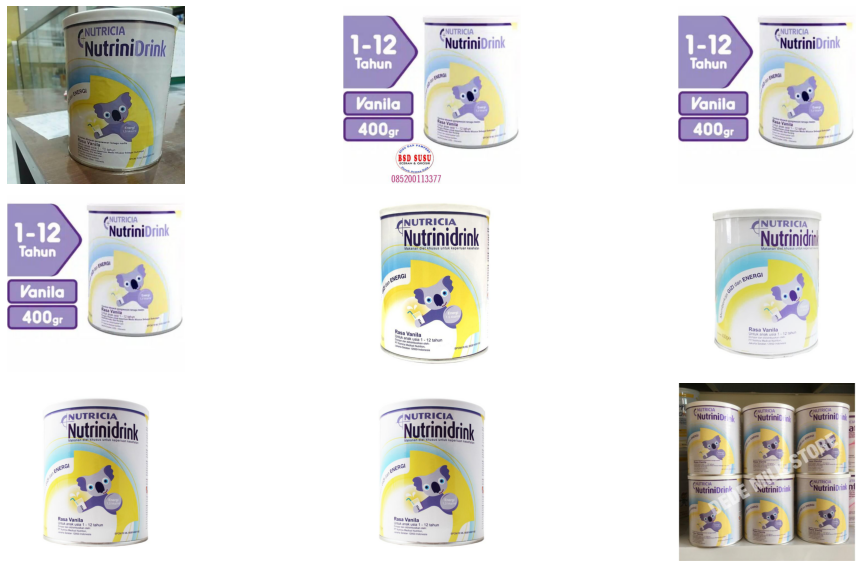

In [8]:
plot_imgs([(img_path + img) for img in list(df[df.label_group==899136538].image)], 3, 3)

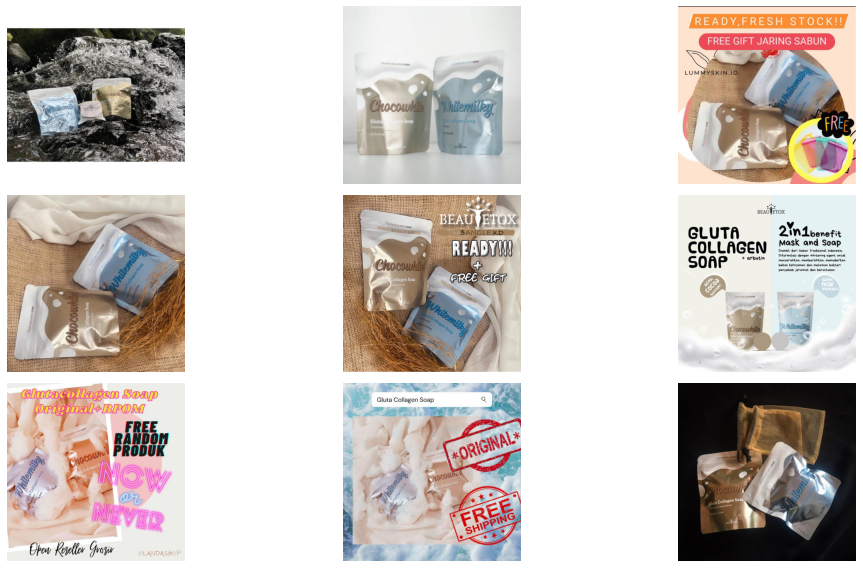

In [9]:
plot_imgs([(img_path + img) for img in list(df[df.label_group==159351600].image)], 3, 3)

## Embeddings
Now let's prepare some embeddings using pretrained MobileNet from torchvision for simplicity (you can use any model you want, the main goal now is to obtain vector representations of the images)

In [10]:
model = models.mobilenet_v2(pretrained=True)

In [11]:
data_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval();

In [28]:
BATCH_SIZE = 16
embeddings = []

for i in tqdm(range(0, df.shape[0], BATCH_SIZE)):
    image_names = list(df.image[i:i+BATCH_SIZE])
    images = []
    for name in image_names:
        images.append(Image.open(img_path + name).convert('RGB'))
    batch = torch.stack([data_transform(image) for image in images])
    inputs = batch.to(device)
    
    with torch.set_grad_enabled(False):
        output = model(inputs)
        embeddings.extend(output)

100%|██████████| 2141/2141 [31:06<00:00,  1.15it/s]


In [33]:
np_embeddings = [e.cpu().numpy() for e in embeddings]
array = np.array(np_embeddings)

In [34]:
df_embeddings = pd.DataFrame(array)

Let's take a sample from train part for queries and then remove it from dataset

In [85]:
queries_subset = df_embeddings.sample(n=50, random_state=42).reset_index(drop=True)
queries_subset_meta = df.sample(n=50, random_state=42).reset_index(drop=True)

In [86]:
df_embeddings = df_embeddings.drop(queries_subset.index).reset_index(drop=True)
df = df.drop(queries_subset_meta.index).reset_index(drop=True)

## Uploading data to Vektonn

Adding embeddings 

In [89]:
df_embeddings.to_csv(vektonn_data_path / 'vectors-df.csv', header=False, index=False)

And metadata (this is optional - you can remove the corresponding variable on the next step to avoid metadata uploading, but let's do it for our case to analyze the results of the queries)

In [90]:
df.to_json(vektonn_data_path / 'vectors-metadata.json', orient='records')

## Search in Vektonn

Now we need to run Vektonn.

1. We have already saved our vectors to directory vektonn/.data-samples.
2. Now we need to run command ./docker-compose-up.sh from the Vektonn directory.

Let's send a test query and see what we're gonna receive. So, for example, the query image is:

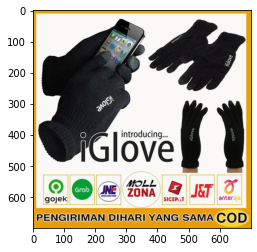

In [91]:
plt.imshow(Image.open(img_path + queries_subset_meta.image[4]).convert('RGB'));

And query for it (should return 3 nearest neighbors):

In [230]:
headers = {"Content-Type": "application/json"}

body = json.dumps({
  "k": "3",
  "vectors": [
    {
      "isSparse": False,
      "dimension": queries_subset.shape[1],
      "coordinates": queries_subset.iloc[[4]].values[0].tolist()
    }
  ]
})

In [234]:
result = requests.post('http://localhost:8080/api/v1/Search', data=body, headers=headers)

In [235]:
result

<Response [200]>

In [250]:
result_imgs = [result.json()[0][i]['data']['image'] for i in range(3)]

Let's see what we got as a result of our test query.
* First image is the duplicate of the query image itself (there are a lot of duplicates in the whole train dataset as it was composed using images of different products from different online marketplaces).
* Second image looks like an image of the same product but from different angles, which is also a good result of the search.
* And the last one is kinda bad guess, which was expected as we used a very simple method of embeddings extraction in this example.

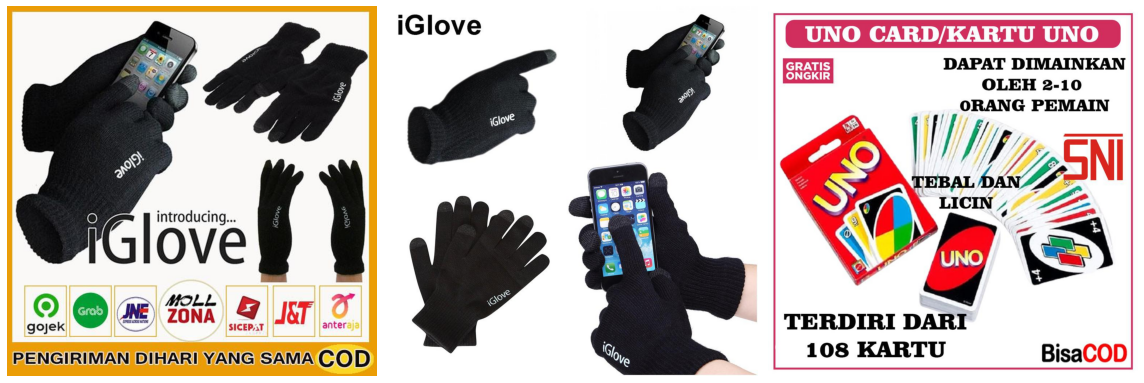

In [251]:
plot_imgs([(img_path + img) for img in result_imgs], 1, 3)